Here we should make sure that a single Transformer model can learn to translate both src->trg and trg->src.

In [1]:
import sys; sys.path += ['..', '../src']

In [2]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split() for s in train_src]
train_trg = [s.split() for s in train_trg]
val_src = [s.split() for s in val_src]
val_trg = [s.split() for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]

In [5]:
# from importlib import reload
# import src.utils.data_utils
# import src.transformer.modules

# reload(src.utils.data_utils)
# reload(src.transformer.models)

<module 'src.transformer.modules' from '../src/transformer/modules.py'>

In [6]:
import tqdm

from src.transformer.models import Transformer

max_len = 50

model = Transformer(
    len(vocab_src),
    len(vocab_trg),
    max_len,
    n_layers=4,
    n_head=4,
    d_word_vec=512,
    d_model=512,
    d_inner_hid=1024,
    d_k=64,
    d_v=64)

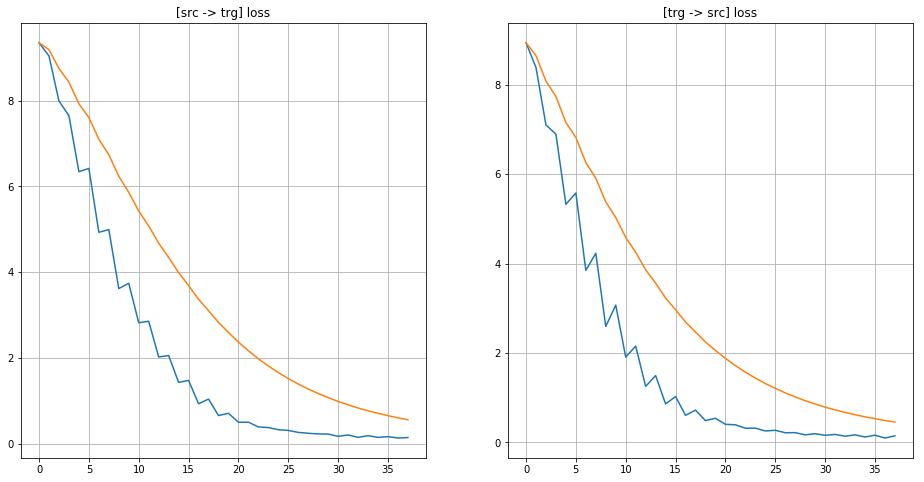

KeyboardInterrupt: 

In [7]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
tqdm.monitor_interval = 0

from src.utils.data_utils import Batcher
import src.transformer.constants as constants


def get_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)


optimizer = Adam(model.get_trainable_parameters())
criterion_src_to_trg = get_criterion(len(vocab_trg))
criterion_trg_to_src = get_criterion(len(vocab_src))
training_data = Batcher(train_src_idx[:8], train_trg_idx[:8], vocab_src.token2id, vocab_trg.token2id, batch_size=4)

model.train()
loss_src_to_trg_history = []
loss_trg_to_src_history = []
num_iters_done = 0
max_num_epochs = 100

for i in range(max_num_epochs):
    for batch in tqdm(training_data, leave=False):
        # prepare data
        src, trg = batch

        # forward
        optimizer.zero_grad()
        pred_trg = model(src, trg)
        pred_src = model(trg, src, use_trg_embs_in_encoder=True, use_src_embs_in_decoder=True)

        # backward
        loss_src_to_trg = criterion_src_to_trg(pred_trg, trg[:, 1:].contiguous().view(-1))
        loss_trg_to_src = criterion_trg_to_src(pred_src, src[:, 1:].contiguous().view(-1))
        
        loss_src_to_trg.backward()
        loss_trg_to_src.backward()

        # update parameters
        optimizer.step()

        loss_src_to_trg_history.append(loss_src_to_trg.data[0])
        loss_trg_to_src_history.append(loss_trg_to_src.data[0])
        num_iters_done += 1

        if num_iters_done % 2 == 0:
            clear_output(True)
            
            plt.figure(figsize=[16,8])
            
            plt.subplot(121)
            #plt.figure(figsize=[16,8])
            plt.title("[src -> trg] loss")
            plt.plot(loss_src_to_trg_history)
            plt.plot(pd.DataFrame(np.array(loss_src_to_trg_history)).ewm(span=20).mean())
            plt.grid()
            
            plt.subplot(122)
            #plt.figure(figsize=[16,8])
            plt.title("[trg -> src] loss")
            plt.plot(loss_trg_to_src_history)
            plt.plot(pd.DataFrame(np.array(loss_trg_to_src_history)).ewm(span=20).mean())
            plt.grid()
            
            plt.show()

In [9]:
batch = next(training_data)

In [10]:
translations = model.translate_batch(batch[0], max_len=20, beam_size=2)
translations = np.array(translations)

100%|██████████| 20/20 [00:01<00:00, 11.80it/s]


In [11]:
for i in range(len(translations)):
    print('Translated:', vocab_trg.remove_bpe(vocab_trg.detokenize(translations[i])))
    print('Real      :', vocab_trg.remove_bpe(vocab_trg.detokenize(batch[1].data[i])))
    print()

Translated: Männer mit Schutzhelmen bedienen ein Antriebsradsystem . . . . . . . der Nähe
Real      : Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche . __PAD__

Translated: mit Schutzhelmen bedienen ein Antriebsradsystem . . . . . . . ein Fenster .
Real      : Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem . __PAD__ __PAD__

Translated: mit Schutzhelmen bedienen ein Antriebsradsystem . ein Fenster . . . der andere Mann sein
Real      : Ein kleines Mädchen klettert in ein Spielhaus aus Holz . __PAD__ __PAD__ __PAD__ __PAD__

Translated: mit Schutzhelmen bedienen ein Antriebsradsystem . . . . . . . . ein Fenster
Real      : Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster .

